# Age recognition 

**Authors**: Richard Šléher, Tomáš Majerník

**Dataset**: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/code?select=train.csv

In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from summarytools import dfSummary
import random
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageOps
import torch.optim as optim
import torch.nn as nn

Hyperparameters

In [2]:
IMAGE_SIZE = 224
epoch = 30
batch_size = 32
lr = 0.1e-4

## EDA

In [3]:
data = pd.read_csv('data/train.csv')

In [4]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 9896.jpg2. 377.jpg3. 7038.jpg4. 10812.jpg5. 11803.jpg6. 22630.jpg7. 9733.jpg8. 6149.jpg9. 10025.jpg10. 14939.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)19,896 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"10,804 (54.3%)6,706 (33.7%)2,396 (12.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [5]:
train_df, temp_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

In [6]:
dfSummary(train_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 4281.jpg2. 11313.jpg3. 8286.jpg4. 17840.jpg5. 19544.jpg6. 20151.jpg7. 20650.jpg8. 19213.jpg9. 10407.jpg10. 10390.jpg11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)15,914 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"8,623 (54.2%)5,376 (33.8%)1,925 (12.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bMWrjYBSF0adBhKSRMAYvxouYxc4itBtjrCIJaZQiXYY4jeZK8+ecFTybDxsZ325ZloKEX1sfwM/RVdVTVT1sfUhD3pZledn6iD3qj8fj72EYDlsf0op5nq9d1/0R3N/6YRgO5/P5ZRzH162P+d/dbrfHaZoOl8vloarE9klfVTWO4+vpdHre+phGPG19wF55QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGTF/18T+srQ9pgffxvn6e5+s0TYfyP6xVzPN8raq3re/YIxuE9dkgfKEz5SOlxU82nyw71dy6yrppv5paV1k37VuL6ypP1TvlR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxDS1rmrldbSquXWVddN+2SAQY11FjAcEYtb+GvUVxpdWnfKZ0XHPalM+Mzq+s/aUr4mfT/g3PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2a1KZ8ZHd9ZdcpnRsc9NgjEmPIR8w5KvKNKilfZywAAAABJRU5ErkJggg=="">",0(0.0%)


In [7]:
dfSummary(valid_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 22281.jpg2. 22413.jpg3. 6343.jpg4. 20981.jpg5. 4088.jpg6. 7096.jpg7. 21824.jpg8. 10674.jpg9. 12480.jpg10. 26352.jpg11. other,"1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1,981 (99.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"1,106 (55.5%)639 (32.1%)246 (12.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmklEQVR4nO3bQWrbYBSF0aciQjORMAYvxovoYrsI7cYYa9CETJRBCoXSJhPlSv5zzgoe5sNGwrdblqUg4dvWB/B1dFX1WFUPWx/SoJdlWZ62PmJP+uPx+GMYhsPWh7Rmnudr13U/BfdHPwzD4Xw+P43j+Lz1Ma243W7fp2k6XC6Xh6oS2299VdU4js+n0+nX1sc05nHrA/bGAwIxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2Yvqqt/9fbX1IS3ye/9bP83ydpulQ/n+1qnmer1X1svUde2KD8HlsEP7SmfKR0tI3m2+SnWtmXWXNtH9NrKusme5DS+sqT9M756UuMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmKaWFfd+/1fRTPrKmum/bNBIMa6ihgPCMSs/TPqp4z/WnXKZ07He1ab8pnT8ZG1p3x3/fqEz+UBgRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxq035zOn4yKpTPnM63mODQIwpHzGvSryjSsmnxUoAAAAASUVORK5CYII="">",0(0.0%)


In [8]:
dfSummary(test_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[object],1. 16929.jpg2. 20491.jpg3. 7139.jpg4. 18650.jpg5. 11812.jpg6. 20573.jpg7. 8737.jpg8. 20586.jpg9. 5132.jpg10. 13156.jpg11. other,"1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1,981 (99.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Class[object],1. MIDDLE2. YOUNG3. OLD,"1,075 (54.0%)691 (34.7%)225 (11.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmklEQVR4nO3bQWrbYBSF0aciQjORMAYvxovoYrsI7cYYa9CETNRBZy1NMhD3V/+es4Jn82Ej4zts21aQ8KX1Afw/hqp6rqqn1od05G3btpfWRxzReD6fv03TdGp9SC/Wdb0Pw/BdcH8ap2k6Xa/Xl3meX1sf8697PB5fl2U53W63p6oS22/Gqqp5nl8vl8uP1sd04rn1AUflAYEYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWPVr/9htT6kB97H943rut6XZTmV/2HtYl3Xe1W9tb7jiGwQ9meD8BeDKR8pPX+y+YQ5mG7XVVZOx9PlusrK6Zh6Xld5uj4YP+oSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI6bLdVVvr6cX3a6rrJyOxwaBGOsqYjwgELPn16ivLd6125TPdI6P7DLlM53jM/ac8nX10wn784BAjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZhdpnymc3zGblM+0zk+YoNAjCkfMT8BvvGjSmv26AkAAAAASUVORK5CYII="">",0(0.0%)


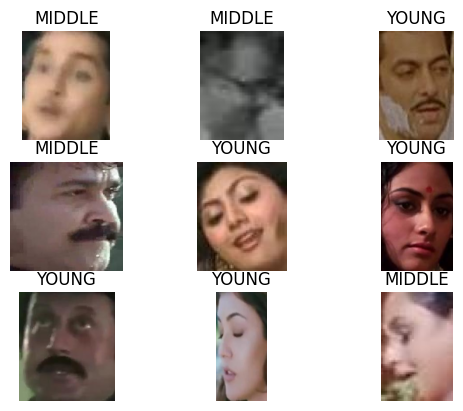

In [9]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread('data/train/' + train_df.iloc[i]['ID'])
    plt.imshow(img)
    plt.title(train_df.iloc[i]['Class'])
    plt.axis('off')

plt.show()

In [10]:
def augment_images(dataframe, train_folder: str, output_folder: str, size: tuple) -> None: 
    if not os.path.exists(output_folder): 
        os.makedirs(output_folder) 
    
    for idx in range(len(dataframe)):
        filename = f"{dataframe.iloc[idx, 0]}"
        img_path = os.path.join(train_folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Skipping missing image: {filename}")
            continue
        
        img = img.resize(size)
        img = ImageOps.autocontrast(img)
        img.save(os.path.join(output_folder, filename))


In [11]:
augment_images(train_df, 'data/Train/', 'data/TrainResized/', size=(IMAGE_SIZE, IMAGE_SIZE))
augment_images(valid_df, 'data/Train/', 'data/ValidResized/', size=(IMAGE_SIZE, IMAGE_SIZE))
augment_images(test_df, 'data/Train/', 'data/TestResized/', size=(IMAGE_SIZE, IMAGE_SIZE))

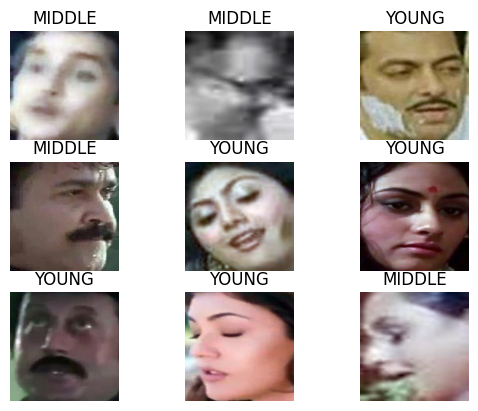

In [12]:
fig = plt.figure()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread('data/TrainResized/' + train_df.iloc[i]['ID'])
    plt.imshow(img)
    plt.title(train_df.iloc[i]['Class'])
    plt.axis('off')

plt.show()

In [13]:
def load_data(dataframe: pd.DataFrame, directory: str, transform: transforms.Compose):
    if not os.path.exists(directory):
        os.makedirs(directory)

    images = []
    labels = []
    for idx in range(len(dataframe)):
        img_name = os.path.join(directory, dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = dataframe.iloc[idx, 1]
        if transform:
            image = transform(image)
        images.append(image)
        labels.append(label)
    return torch.stack(images), labels

In [14]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    total_images_count = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

valid_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_images, train_labels = load_data(train_df, 'data/TrainResized/', train_transform)
valid_images, valid_labels = load_data(valid_df, 'data/ValidResized/', valid_test_transform)
test_images, test_labels = load_data(test_df, 'data/TestResized/', valid_test_transform)

label_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
train_labels = [label_mapping[label] for label in train_labels]
valid_labels = [label_mapping[label] for label in valid_labels]
test_labels = [label_mapping[label] for label in test_labels]

train_loader = [(train_images[i:i + batch_size], train_labels[i:i + batch_size]) for i in range(0, len(train_images), batch_size)]
valid_loader = [(valid_images[i:i + batch_size], valid_labels[i:i + batch_size]) for i in range(0, len(valid_images), batch_size)]
test_loader = [(test_images[i:i + batch_size], test_labels[i:i + batch_size]) for i in range(0, len(test_images), batch_size)]

# Shape of the data for DL model
for images, labels in train_loader:
    print(images.shape, len(labels))
    break


torch.Size([32, 3, 224, 224]) 32


In [16]:
for images, labels in train_loader:
    print(labels)
    break

['MIDDLE', 'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'YOUNG', 'YOUNG', 'YOUNG', 'MIDDLE', 'MIDDLE', 'YOUNG', 'MIDDLE', 'OLD', 'MIDDLE', 'OLD', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'YOUNG', 'YOUNG', 'MIDDLE', 'MIDDLE', 'YOUNG', 'MIDDLE', 'OLD', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE']


## Model

In [17]:
class VGG16(nn.Module):
    def __init__(self, num_classes: int):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [18]:
# Example usage:
model = VGG16(num_classes=3)
print(model)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.tensor(labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epoch}, Loss: {running_loss/len(train_loader)}")

print("Training finished.")

ValueError: too many dimensions 'str'